# Toxic Detection

## Prueba Técnica: Mercado Libre

**Marzo 2023**

*César Daniel Garrido Urbano*


## Descripción

El objetivo es construir un sistema para detectar automáticamente textos que contienen lenguaje ofensivo (inclusive de género, raza, etc...) o vulgar.

Para esto debes generar un modelo de clasificación utilizando un esquema basado en árboles de decisión. (Por ejemplo: Random Forest, XGBoost, LightGBM, etc...).

El proceso de desarrollo debe seguir el flujo completo de modelado en machine learning (análisis de datos, feature engineering, selección de modelo, métricas) con reporte de resultados y proceso. Toda decisión tomada dentro del pipeline debe ser agregada al reporte.

Luego de haber seleccionado el mejor modelo de clasificación, para el reporte, haz un análisis comparativo de los dos mejores modelos que hayas obtenido con la métrica que consideres se adapta mejor al problema.


# Exploración Inicial de los datos

Visualización, split en enetrenamiento y prueba, preprocesamiento (tokenización) y limpieza general de los datos.

In [25]:
# Main libraries
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Set pandas columns option
pd.set_option('display.max_colwidth', 500)
pd.set_option("max_rows", 30)

# Import data
raw_df = pd.read_csv('data_toxic.csv')

# Dataset overview
raw_df

,message,label
0,"Hola, dale actualizar a la pagina o la tecla F5",0
1,Ningún mujer te va a dejar por un error. porque todos somos humanos y el algún momento la cagamos pero siempre hay la oportunidad de mejorar en la cagas que uno hace y más si te hace feliz,1
2,"Entonces, si está haciendo una correspondencia en R ^ 2, ¿cómo dibujaría G (x) = {y es un elemento de R2 tal que el producto escalar de x e y es 0} si G (3,4)",0
3,victoria con el pelito corto me voy a matar,1
4,@LoloPeniche Periodista!!!!!\nEs una puta verdulera la HDSPTM... https://t.co/6wyiTra4ko,1
...,...,...
514550,Argentina: *apoya a la Alemania Nazi en la guerra*\nAlemania: *pierde la guerra*\nArgentina teniendo que explicarle la situación al resto del mundo: https://t.co/eQo4Pqru2r,1
514551,"La rata esta de @robertomadrazo invitando a votar, ya pasó no??, para darle aire a su partido corrupto y hablando de tiranías. No mames ratero que te compre quien no te conoce. https://t.co/T7Xm9ZLJxE",1
514552,No dale no hay problema muchísimas gracias no me sabía ese dato no encuentro problema alguno solo me surgió esa duda espero no haber incómodado muchas gracias,0
514553,"Mi nombre es ""onassis amaya cc 84083683",0


In [3]:
raw_df.groupby(['label']).count()

,message
label,
0,295937
1,218618


In [4]:
# Simplifiación temporal del problema (10.000 mensajes)
sample_df = raw_df.head(10000)

## _Split_ en _training_ y _testing_

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sample_df.message, sample_df.label, test_size=0.20, random_state=42)

## Pre-procesamiento de los datos

### Tokenización

In [6]:
# NLTK 
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [7]:
# Función para estandarizar el preprocesamiento.

def preprocess_text(text, tokenizer=None, stemmer=None, stop_words=None):
    """ Aplica un preprocesamiento estandar a un mensaje (text), tokenizandolo y limpiando los caracteres.
    
    Args:
        text (str): Mensaje a ser preprocesado
        tokenizer (nltk.tokenize.Tokenizer): Tokenizador (Objeto para convertir mensajes en tokens).
        stemmer (nltk.stem.Stemmer): Stemmer (Objeto que normaliza o reduce las palabras a su raiz).
        stop_words ([str]): Lista de palabras a ser removidas por ser tan repetidas (tipicamente articulos).
    
    Returns:
        preprocessed_text ([str]): Lista de tokens preprocesados del mensaje inicial.
    
    """
    
    # Tokenizacion y estandarizacion en minusculas
    text_tk = tokenizer.tokenize(text.lower())
    
    # Remover signos de puntuación + stop words + URLs
    relevant_tk = []
    for tk in text_tk:
        if (tk not in string.punctuation+'¿') and (tk not in stop_words) and ('http' not in tk):
            relevant_tk.append(tk)   
    
    # Stemmer (Cortar finalizacion de la palabra)
    #processed_text=[]
    #for tk in relevant_tk:
    #    processed_text.append(stemmer.stem(tk))
    
    # Returns processed text
    return relevant_tk

In [8]:
# Tokenizador para tweets
tt = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
# Stemmer y stop-words en español
stemmer = SnowballStemmer('spanish')
stop_words = stopwords.words('spanish')

# Tokenize messages
X_train_tk = []
X_test_tk = []

for txt in tqdm(X_train):
    X_train_tk.append(preprocess_text(txt, tt, stemmer, stop_words))
    
for txt in tqdm(X_test):
    X_test_tk.append(preprocess_text(txt, tt, stemmer, stop_words))

100%|██████████| 2000/2000 [00:00<00:00, 5133.97it/s]


In [9]:
# Ejemplo de Tokenización
print("Ejemplos de Tokenización:\n")
print(X_train[2]) 
print(X_train_tk[2])
print("")
print(X_train[4]) 
print(X_train_tk[4])

Ejemplos de Tokenización:

Entonces, si está haciendo una correspondencia en R ^ 2, ¿cómo dibujaría G (x) = {y es un elemento de R2 tal que el producto escalar de x e y es 0} si G (3,4)
['gracias', 'dejar', 'maravillosamente', 'claro', 'importa', 'neutralidad']

@LoloPeniche Periodista!!!!!
Es una puta verdulera la HDSPTM... https://t.co/6wyiTra4ko
['significa', 'texto', 'todavía', 'existe']


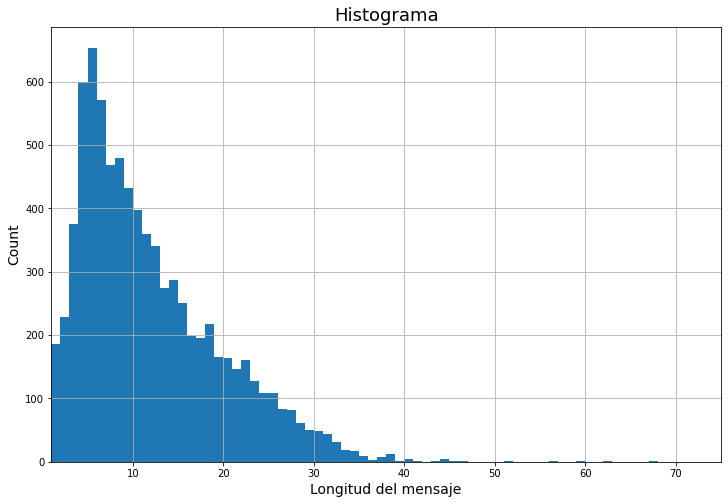

Tamaño promedio (mean) de los mensajes:
11.595125
Tamaño medio (median) de los mensajes:
10.0


In [10]:
# Histograma (Longitud de mensajes)

msgs_length = []
for x in X_train_tk:
    msgs_length.append(len(x))

# Number of bins
bins= np.max(np.array(msgs_length))

# Plot
fig = plt.figure(figsize=(12,8))
plt.hist(np.array(msgs_length), bins=bins)
plt.xlim([1, 75])
plt.xlabel('Longitud del mensaje', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Histograma', fontsize=18)
plt.grid(True)
plt.savefig("histogram.png")
plt.show()

# Print some metrics
print('Tamaño promedio (mean) de los mensajes:')
print(np.mean(np.array(msgs_length)))

print('Tamaño medio (median) de los mensajes:')
print(np.median(np.array(msgs_length)))

## Embeddings

Representación de las sentencias (tokens) como vectores.

In [11]:
from sklearn.decomposition import PCA, IncrementalPCA
from gensim import corpora

D:\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Modelo Bag of Words (BOW)

In [12]:
# Crear diccionario de palabras
dict_msgs = corpora.Dictionary(X_train_tk)
dict_msgs.filter_extremes(no_below=5, no_above=0.5)

print('Diccionario de palabras construido a partir del set de mensajes:')
print(dict_msgs)

Diccionario de palabras construido a partir del set de mensajes:
Dictionary(2792 unique tokens: ['35', 'buenas', 'cra', 'dirección', 'noches']...)


In [13]:
# Crear corpus con representación BOW
train_corpus = []
for msg in X_train_tk:
    train_corpus.append(dict_msgs.doc2bow(msg))
    
test_corpus = []
for msg in X_test_tk:
    test_corpus.append(dict_msgs.doc2bow(msg))

In [14]:
# Crear matriz de caracteristicas BOW
X_train_bow = np.zeros((len(train_corpus), len(dict_msgs)), dtype = np.int32)
X_test_bow = np.zeros((len(test_corpus), len(dict_msgs)), dtype = np.int32)

# Llenar matrices
for i, msg in enumerate(train_corpus):
    for term in msg:
        X_train_bow[i][term[0]] = term[1]
        
for i, msg in enumerate(test_corpus):
    for term in msg:
        X_test_bow[i][term[0]] = term[1]

#### Dimentionality Reduction (PCA)

In [15]:
# PCA (Optional)

#pca = IncrementalPCA(n_components=500, batch_size=10000)
#X_train_bow_pca = pca.fit_transform(X_train_bow)
#X_test_bow_pca = pca.transform(X_test_bow)

### Modelo Word2Vec

In [16]:
from gensim import models

In [21]:
def get_vectors_from_w2v_model(w2v_model, X_tk, agg_method='avg'):
    
    # Convert sentence to vectors
    words = set(w2v_model.wv.index_to_key)
    X_w2v = np.array([np.array([w2v_model_150.wv[i] for i in ls if i in words]) for ls in X_tk])
    
    # Aggregate vectors in sentence
    if agg_method=='avg':
        # Promedio
        X_w2v_agg = []
        for x in X_w2v:
            if len(x) == 0:
                x_avg = np.zeros(vec_size)
            else:
                x_avg = np.mean(x, axis=0)
            X_w2v_agg.append(x_avg)
            
    elif agg_method=='concat':
        # Concatenacion
        X_w2v_agg = []
        for x in X_w2v:
            x_concat = x.flatten()
            if len(x_concat) < 1:
                x_concat = np.zeros(sentence_size)
            elif len(x_concat) < sentence_size:
                x_concat = np.append(x_concat, np.zeros(sentence_size-len(x_concat)))
            elif len(x_concat) > sentence_size:
                x_concat = x_concat[0:sentence_size]
            X_w2v_agg.append(x_concat)
    else:
        raise Exception(f"Sorry, no {agg_method} aggregation method is supported, only 'avg' and 'concat' ")
    
    return X_w2v_agg

#### Promedio

In [19]:
vec_size = 150

# Entrenar modelo W2V
w2v_model_150 = models.Word2Vec(X_train_tk, vector_size=vec_size, window=3, min_count=5, sg=0, negative=10, workers=10)
w2v_model_150.train(X_train_tk, total_examples=len(X_train_tk), epochs=10)

# Obtener vectores de los mensajes
X_train_w2v_avg = get_vectors_from_w2v_model(w2v_model_150, X_train_tk, agg_method='avg')
X_test_w2v_avg = get_vectors_from_w2v_model(w2v_model_150, X_test_tk, agg_method='avg')

<ipython-input-17-6fb92cb5951b>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_w2v = np.array([np.array([w2v_model_150.wv[i] for i in ls if i in words]) for ls in X_tk])


In [ ]:
'''
vec_size = 150

# Entrenar modelo W2V
w2v_model_150 = models.Word2Vec(cleaned_msgs, vector_size=vec_size, window=3, min_count=5, sg=0, negative=10, workers=10)
w2v_model_150.train(cleaned_msgs, total_examples=len(cleaned_msgs), epochs=10)

# Convertir mensajes a vectores W2V
words = set(w2v_model_150.wv.index_to_key )
X_w2v_150 = np.array([np.array([w2v_model_150.wv[i] for i in ls if i in words]) for ls in cleaned_msgs])

# Promedio de la sentencia
X_w2v_avg = []

for x in X_w2v_150:
    if len(x) == 0:
        x_avg = np.zeros(vec_size)
    else:
        x_avg = np.mean(x, axis=0)
    X_w2v_avg.append(x_avg)

'''

#### Concatenadas

In [22]:
n_words = 20
vec_size = 50
sentence_size = n_words*vec_size

# Entrenar modelo W2V
w2v_model_50 = models.Word2Vec(X_train_tk, vector_size=vec_size, window=3, min_count=5, sg=0, negative=10, workers=10)
w2v_model_50.train(X_train_tk, total_examples=len(X_train_tk), epochs=10)

# Obtener vectores de los mensajes
X_train_w2v_concat = get_vectors_from_w2v_model(w2v_model_50, X_train_tk, agg_method='concat')
X_test_w2v_concat = get_vectors_from_w2v_model(w2v_model_50, X_test_tk, agg_method='concat')

<ipython-input-21-f052c847cbf0>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_w2v = np.array([np.array([w2v_model_150.wv[i] for i in ls if i in words]) for ls in X_tk])


In [ ]:
'''
n_words = 20
vec_size = 50
sentence_size = n_words*vec_size

# Entrenar modelo W2V
w2v_model_50 = models.Word2Vec(cleaned_msgs, vector_size=vec_size, window=3, min_count=5, sg=0, negative=10, workers=10)
w2v_model_50.train(cleaned_msgs, total_examples=len(cleaned_msgs), epochs=10)

# Convertir mensajes a vectores W2V
words = set(w2v_model_50.wv.index_to_key )
X_w2v_50 = np.array([np.array([w2v_model_50.wv[i] for i in ls if i in words]) for ls in cleaned_msgs])

# Concatenacion de las primeras 20 palabras
X_w2v_concat = []

for x in X_w2v_50:
    x_concat = x.flatten()
    if len(x_concat) < 1:
        x_concat= np.zeros(sentence_size)
    elif len(x_concat) < sentence_size:
        x_concat = np.append(x_concat, np.zeros(sentence_size-len(x_concat)))
    elif len(x_concat) > sentence_size:
        x_concat = x_concat[0:sentence_size]
        
    X_w2v_concat.append(x_concat)

'''

In [23]:
# Verificación de cantidad de mensajes que fallaron en la vectorización
failed_count = 0
for x in X_test_bow:
    if x.sum()==0:
        failed_count +=1

print("BOW")
print(f"Número de mensajes en blanco: {failed_count}")

failed_count = 0
for x in X_test_w2v_avg:
    if x.sum()==0:
        failed_count +=1

print()
print("W2V")
print(f"Número de mensajes en blanco: {failed_count}")

BOW
Número de mensajes en blanco: 10

W2V
Número de mensajes en blanco: 10


### Modelo Deep (Transformer Pre-Entrenado)

In [26]:
from sentence_transformers import SentenceTransformer

transformer_model = SentenceTransformer('hackathon-pln-es/paraphrase-spanish-distilroberta')

# Preprocesamiento simple - remover URLs y usuarios (Sin Tokenizar)
def simple_preprocess_text(X):
    X_pre = []
    for x in X:
        x_pre = re.sub(r"http\S+", "", x)
        x_pre = re.sub(r"@S+", "", x_pre)
        X_pre.append(x_pre)
    return X_pre

# Encode embeddings
X_train_deep = transformer_model.encode(simple_preprocess_text(X_train))
X_test_deep = transformer_model.encode(simple_preprocess_text(X_test))

You try to use a model that was created with version 2.2.0, however, your version is 2.0.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





# Selección de Modelo

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [28]:
def train_test_models(model, X_train, y_train, X_test, y_test, model_id='Model', test_id='001'):
    """ Entrena y prueba modelo de clasificación binaria.
    
    Args:
        model (model): Modelo a ser entrenado y probado.
        X (np.array): Representación de los mensajes en vectores (BOW, Word2Vec, DeepEmbeddings)
        y (np.array): Etiqueta de la clase (0 o 1)
        model_id (str): Id para identificar modelo
    
    Returns:
        results (dict): Metricas de evaluación 
    
    """    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metricas de performance
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    # Resultados
    results = {'Model': model_id, 'Test': test_id , 'Accuracy': accuracy,
               'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}
    
    return results

## Decision Trees

In [30]:
dt_clf = DecisionTreeClassifier()

# BOW
results = train_test_models(dt_clf, X_train_bow, y_train, X_test_bow, y_test, model_id='DT', test_id='BOW')
results_df = pd.DataFrame.from_dict([results])

# results = train_test_models(dt_clf, X_train_bow_pca, y_train, X_train_bow_pca, y_test, model_id='DT', test_id='BOW-PCA')
# results_df = results_df.append(results, ignore_index=True)

# Word2Vec
results = train_test_models(dt_clf, X_train_w2v_avg, y_train, X_test_w2v_avg, y_test, model_id='DT', test_id='W2V-Avg')
results_df = results_df.append(results, ignore_index=True)

results = train_test_models(dt_clf, X_train_w2v_concat, y_train, X_test_w2v_concat, y_test, model_id='DT', test_id='W2V-Concat')
results_df = results_df.append(results, ignore_index=True)

# Deep
results = train_test_models(dt_clf, X_train_deep, y_train, X_test_deep, y_test, model_id='DT', test_id='Deep')
results_df = results_df.append(results, ignore_index=True)

## RandomForest

In [31]:
rf_clf = RandomForestClassifier(verbose=1, n_jobs=-2)

# BOW
results = train_test_models(rf_clf, X_train_bow, y_train, X_test_bow, y_test, model_id='RF', test_id='BOW')
results_df = results_df.append(results, ignore_index=True)

# results = train_test_models(rf_clf, X_train_bow_pca, y_train, X_train_bow_pca, y_test, model_id='RF', test_id='BOW-PCA')
# results_df = results_df.append(results, ignore_index=True)

# Word2Vec
results = train_test_models(rf_clf, X_train_w2v_avg, y_train, X_test_w2v_avg, y_test, model_id='RF', test_id='W2V-Avg')
results_df = results_df.append(results, ignore_index=True)

results = train_test_models(rf_clf, X_train_w2v_concat, y_train, X_test_w2v_concat, y_test, model_id='RF', test_id='W2V-Concat')
results_df = results_df.append(results, ignore_index=True)

# Deep
results = train_test_models(rf_clf, X_train_deep, y_train, X_test_deep, y_test, model_id='RF', test_id='Deep')
results_df = results_df.append(results, ignore_index=True)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    0

## XGBoost

In [32]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# BOW
results = train_test_models(xgb_clf, X_train_bow, y_train, X_test_bow, y_test, model_id='XGB', test_id='BOW')
results_df = results_df.append(results, ignore_index=True)

# results = train_test_models(xgb_clf, X_train_bow_pca, y_train, X_train_bow_pca, y_test, model_id='RF', test_id='BOW-PCA')
# results_df = results_df.append(results, ignore_index=True)

# Word2Vec
results = train_test_models(xgb_clf, X_train_w2v_avg, y_train, X_test_w2v_avg, y_test, model_id='XGB', test_id='W2V-Avg')
results_df = results_df.append(results, ignore_index=True)

results = train_test_models(xgb_clf, X_train_w2v_concat, y_train, X_test_w2v_concat, y_test, model_id='XGB', test_id='W2V-Concat')
results_df = results_df.append(results, ignore_index=True)

# Deep
results = train_test_models(xgb_clf, X_train_deep, y_train, X_test_deep, y_test, model_id='XGB', test_id='Deep')
results_df = results_df.append(results, ignore_index=True)

# Resultados

In [38]:
results_df.sort_values(by='Accuracy', ascending=False)

,Model,Test,Accuracy,Precision,Recall,F1-Score
8,XGB,BOW,0.9470,0.972833,0.898447,0.934161
4,RF,BOW,0.9465,0.960859,0.909200,0.934316
11,XGB,Deep,0.9445,0.941606,0.924731,0.933092
0,DT,BOW,0.9345,0.927361,0.915173,0.921227
5,RF,W2V-Avg,0.9315,0.939698,0.893668,0.916105
7,RF,Deep,0.9315,0.947570,0.885305,0.915380
9,XGB,W2V-Avg,0.9305,0.936250,0.894863,0.915089
10,XGB,W2V-Concat,0.9230,0.922126,0.891278,0.906440
6,RF,W2V-Concat,0.9200,0.913309,0.893668,0.903382
1,DT,W2V-Avg,0.8910,0.868892,0.870968,0.869928


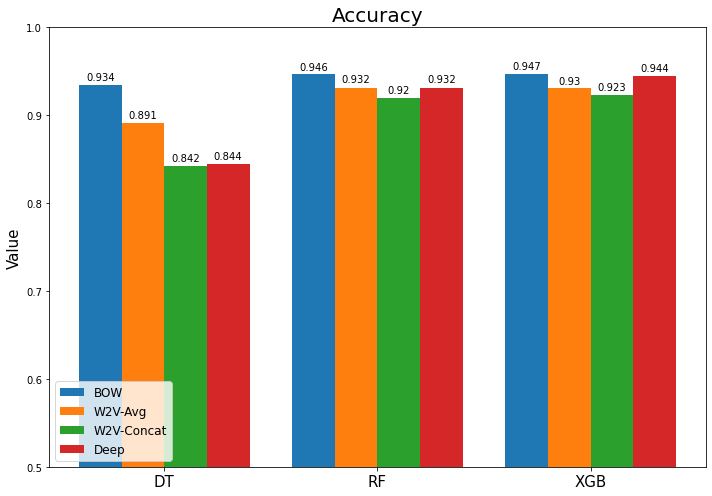

In [35]:
# Labels
labels = ['DT', 'RF', 'XGB']

# Data
BOW = results_df.loc[results_df['Test'] == 'BOW']['Accuracy'].values
W2V_AVG = results_df.loc[results_df['Test'] == 'W2V-Avg']['Accuracy'].values
W2V_Concat = results_df.loc[results_df['Test'] == 'W2V-Concat']['Accuracy'].values
DEEP = results_df.loc[results_df['Test'] == 'Deep']['Accuracy'].values

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Create plot
fig, ax = plt.subplots(figsize=(10,7))

# Locate bar graphs
rects1 = ax.bar(x - 3*width/2, BOW, width, label='BOW')
rects2 = ax.bar(x - width/2, W2V_AVG, width, label='W2V-Avg')
rects3 = ax.bar(x + width/2, W2V_Concat, width, label='W2V-Concat')
rects4 = ax.bar(x + 3*width/2, DEEP, width, label='Deep')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value', fontsize=15)
ax.set_title("Accuracy", fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=15)
ax.set_ylim((0.5, 1))
ax.legend(loc=3, fontsize=12)

# Autolabel bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Label bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Plot
fig.tight_layout()
fig.savefig('./results/accuracy.png')
plt.show()